<h1 style="font-family: monospace; color: orange; text-align: center; font-size: 50px;"> 
    Poker Player Patterns
</h1><br />

The data needed is [here](https://www.kaggle.com/smeilz/poker-holdem-games#Export%20Holdem%20Manager%202.0%2012292016131233.txt), specific file used is 
<span style="color: black; color: orange; font-weight: bold;">
    Export Holdem Manager 2.0 12302016144830.txt
</span>.
<br />
It represents a game of over 40 000 rounds played on a table with real money (prbbly in dolars).

## Environment settings
We will use a couple of libraries, with outside dependancies being matplotlib and pandas.
From our library we will require only the enums, as they identify some ids included in the csv files.

In [64]:
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from lib import ActionId, TurnId

# rounds gathered (last one is not finished)
MAX_ROUND = 42688 - 1
# user that provided the data (sometimes deviates highly)
MAIN_USER = 'IlxxxlI'

nrowdisplay = 10
max_round, min_played = 10000, 10
pd.options.display.max_rows = nrowdisplay

# monkeypatch ungroup to pandas
pd.core.frame.DataFrame.ungroup = (
    lambda self: self.reset_index().drop(
        columns = ['level_0', 'level_1', 'level_2'],
        errors = 'ignore'
    )
)

# default ax configuration
def setAxConfig(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

## Load csv
Here we load the parsed and later tidied data. <br />
Because there are many files and we have to do similar things for each one, there is a loop that takes care of all and also reduces readability. <br />
We will often combine columns of different data frames without merging them by 
<span style="font-family: monospace;">user_id</span> column, therefore we must sort them (all users are accounted for as we made sure when the data was tidied).

In [65]:
load_path = Path.cwd() / 'tidy_data'

for file in load_path.iterdir():
    data = pd.read_csv(file)
    if 'round_id' in data.columns:
        data = data[data.round_id <= max_round]
    if 'user_id' in data.columns:
        data = data.sort_values('user_id')
    globals()[file.stem] = data

user_dict = list(user_ids.user)
main_user_id = user_dict.index(MAIN_USER)

## Correlations
We'll gather some basic information about the players and show some correlations. These will serve us as a rough insight into players' general behaviour, which we'll later try to improve. In this section we will treat bets as raises as they actually are raises in some form.

### Folds and Raises vs. Winnings
We will check if the fold average of a player has any effect on his winnings. <br />
This is a rough estimate of player's low agression level, which we will analyse later on.

In [66]:
def actionSummary(df):
    count = Counter(df.action_id)
    return {
        action.name: [count[int(action)]]
        for action in ActionId
    }
        
action_summary = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            **actionSummary(df),
            'all_actions': [len(df.action_id)]
        }
    )
).ungroup()

In [67]:
winnings = cardshow.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'total_won': [df.amount.sum()],
            'mean_won': [df.amount.mean()]
        }
    )
).ungroup()

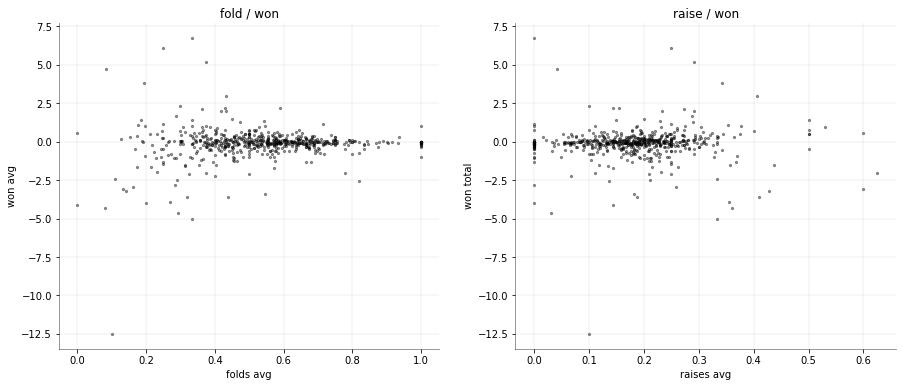

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxConfig(ax1, 'fold / won', 'folds avg', 'won avg')
setAxConfig(ax2, 'raise / won', 'raises avg', 'won total')

temp_act = action_summary[action_summary.user_id != main_user_id]
temp_won = winnings[winnings.user_id != main_user_id]

ax1.scatter(
    temp_act.FOLD / temp_act.all_actions, 
    temp_won.mean_won,
    s=5, c='black', alpha=0.4
)
ax2.scatter(
    (temp_act.RAISE + temp_act.BET) / temp_act.all_actions,
    temp_won.mean_won, 
    s=5, c='black', alpha=0.4
);

We see here that folding more often stabilizes relative winnings a bit, which makes sense. Other than that there is no real correlation here.

### Raises vs. Folds and Raise Amount
Here we will check the correlation between players' raises and folds.
We assume players that raise more fold less as they are generally more agressive.

In [69]:
raise_stats = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_raise': [
                df[
                    (df.action_id == ActionId.RAISE) |
                    (df.action_id == ActionId.BET)
                ].amount.mean()
            ]
        }
    )
).ungroup()
raise_stats.avg_raise = raise_stats.avg_raise.replace(pd.NaT, 0)

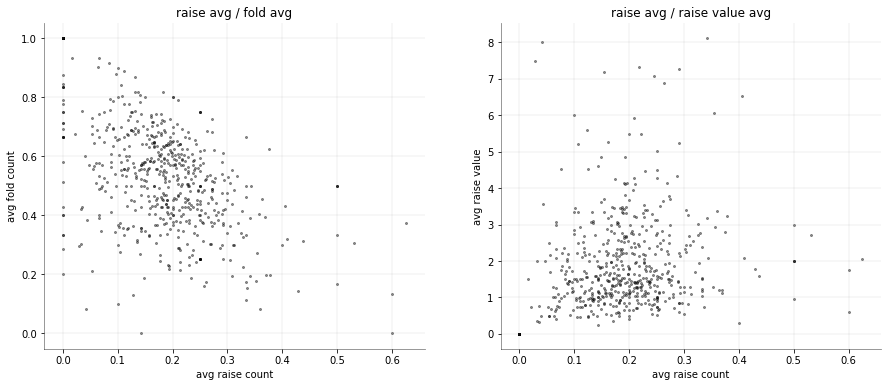

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxConfig(ax1, 'raise avg / fold avg', 'avg raise count', 'avg fold count')
setAxConfig(ax2, 'raise avg / raise value avg', 'avg raise count', 'avg raise value')

ax1.scatter(
    (temp_act.RAISE + temp_act.BET) / temp_act.all_actions,
    temp_act.FOLD / temp_act.all_actions,
    s=4, c='black', alpha=0.4
);
ax2.scatter(
    (temp_act.RAISE + temp_act.BET) / temp_act.all_actions,
    raise_stats.avg_raise[raise_stats.user_id != main_user_id], 
    s=4, c='black', alpha=0.4
);

While there seems to be only a slight correlation between average raise and fold count there seems a more obvious one with the average raise count and raise amount. We see that the more frequently people raised, the largest bets they made. Those people are probably the agressives we wish to analyse.

## Agression Based Clustering
We will try to define player's agression level and analyse it further.

### Probability Of Folding To A Raise
Let's see how likely it is for a player to fold after being raised.

In [116]:
def turn_summary(df):
    player_raise = {user: 0 for user in df.user_id}
    player_fold = {user: 0 for user in df.user_id}
    current_stake = 0
    for i, row in df.sort_values('action_order').iterrows():
        if row.action_id in [
            ActionId.RAISE, 
            ActionId.BET, 
            ActionId.ALLIN
        ]:
            player_raise[row.user_id] = row.amount
            current_stake += row.amount
        elif row.action_id == ActionId.FOLD:
            player_fold[row.user_id] = (
                current_stake - 
                player_raise[row.user_id]
            )
    return pd.DataFrame(
        data = {
            'user_id': list(player_fold.keys()),
            'folded_to': list(player_fold.values()),
            'has_folded': [v == 0 for v in player_fold.values()]
        }
    )

folded_to = actions.groupby(
    ['round_id', 'turn']
).apply(
    turn_summary
).ungroup().groupby(
    ['round_id', 'user_id']
).mean().ungroup()

In [197]:
has_folded = folded_to.has_folded.mean()
avg_fold = folded_to.folded_to[data.has_folded].mean()

def classifyPlayer(df):
    hf, ft = (
        df.has_folded.mean(), 
        df.folded_to[df.has_folded].mean()
    )
    if not isinstance(ft, int): ft = 0
    if hf < has_folded and ft < avg_fold:
        return 'agressive'
    elif hf > has_folded:
        return 'non_agressive'
    else:
        return 'neither'
    
classified = folded_to.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'status': [classifyPlayer(df)]
        }
    )
).ungroup()

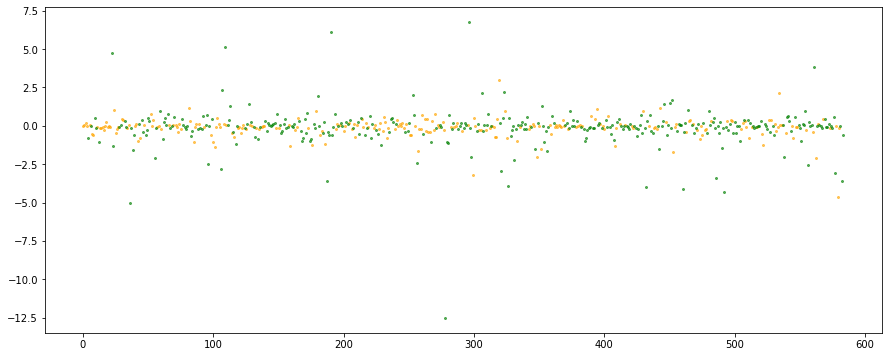

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
setAxConfig(ax1, '', '', 'avg winnings')

p1 = classified[classified.status == 'agressive'].merge(
    winnings, 'outer', 'user_id'
).dropna()
p2 = classified[classified.status == 'non_agressive'].merge(
    winnings, 'outer', 'user_id'
).dropna()

ax.scatter(
    p1.user_id, p1.mean_won,
    s=4, c='orange', alpha=0.6
);
ax.scatter(
    p2.user_id, p2.mean_won,
    s=4, c='green', alpha=0.6
);

In [189]:
winnings

,user_id,total_won,mean_won
0,0,-1.48,-0.001945
1,1,0.63,0.028636
2,2,92.87,0.171347
3,3,-1.60,-0.040000
4,4,-25.23,-0.788438
...,...,...,...
579,579,-60.56,-4.658462
580,580,-1.60,-0.160000
581,581,-0.16,-0.013333
582,582,-35.72,-3.572000


## 250 Best Players

## Best Player Behavior